# Домашнее задание. Convolutional neural network.

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

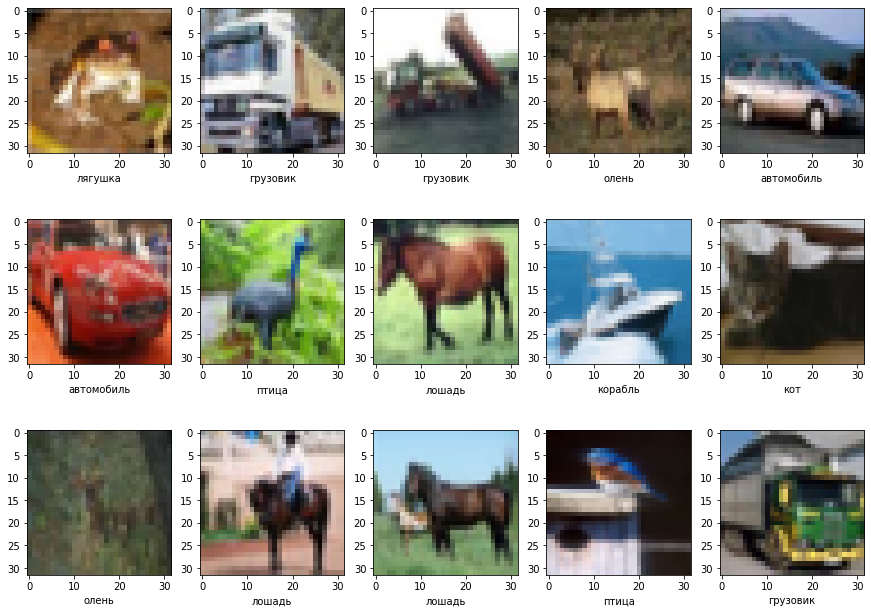

In [4]:
N = 15
plt.figure(figsize=(15, 11))
for i in range(N):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_train[i,:,:,:])
    plt.xlabel(classes[np.argmax(y_train[i, :])])
plt.show()

Напишем функции для добавления слоев.

In [5]:
def add_conv_pool(model, kernels_number, kernel, padding='same',
                  conv_number=2, input_shape=None, activation='relu', pool_size=(2, 2)):
    for i in range(conv_number):
        if input_shape and (i == 0):
            model.add(Conv2D(kernels_number, kernel, padding=padding, input_shape=input_shape))
            model.add(Activation(activation))
        else:
            model.add(Conv2D(kernels_number, kernel, padding=padding))
            model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))


def add_dense(model, neurons_numbers, dense_number=2, activations=['relu', 'softmax']):
    model.add(Flatten())
    for i in range(dense_number):
        model.add(Dense(neurons_numbers[i]))
        model.add(Activation(activations[i]))

Построим модель с 2мя блоками слоев (Conv, Pool) и 2мя плотными слоями (Dense).

In [6]:
model = Sequential()

add_conv_pool(model, 32, (3, 3), input_shape=x_train.shape[1:])
add_conv_pool(model, 64, (3, 3))
add_dense(model, [256, 10])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

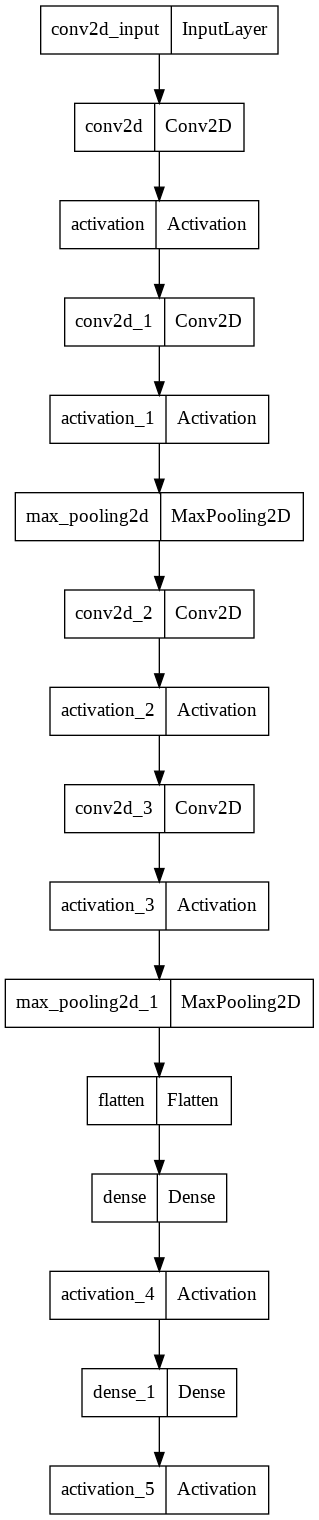

In [7]:
plot_model(model)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

In [10]:
hist = model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 16s 6ms/step - loss: 1.4091 - accuracy: 0.4863 - val_loss: 1.0732 - val_accuracy: 0.6135
Epoch 2/5
1250/1250 [==============================] - 7s 5ms/step - loss: 0.9148 - accuracy: 0.6793 - val_loss: 0.8318 - val_accuracy: 0.7123
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7246 - accuracy: 0.7452 - val_loss: 0.7732 - val_accuracy: 0.7302
Epoch 4/5
1250/1250 [==============================] - 7s 5ms/step - loss: 0.5731 - accuracy: 0.7981 - val_loss: 0.7545 - val_accuracy: 0.7401
Epoch 5/5
1250/1250 [==============================] - 7s 5ms/step - loss: 0.4486 - accuracy: 0.8425 - val_loss: 0.7765 - val_accuracy: 0.7485


Построим несколько моделей CNN с разным количеством ядер и посмотрим зависимость на графике.

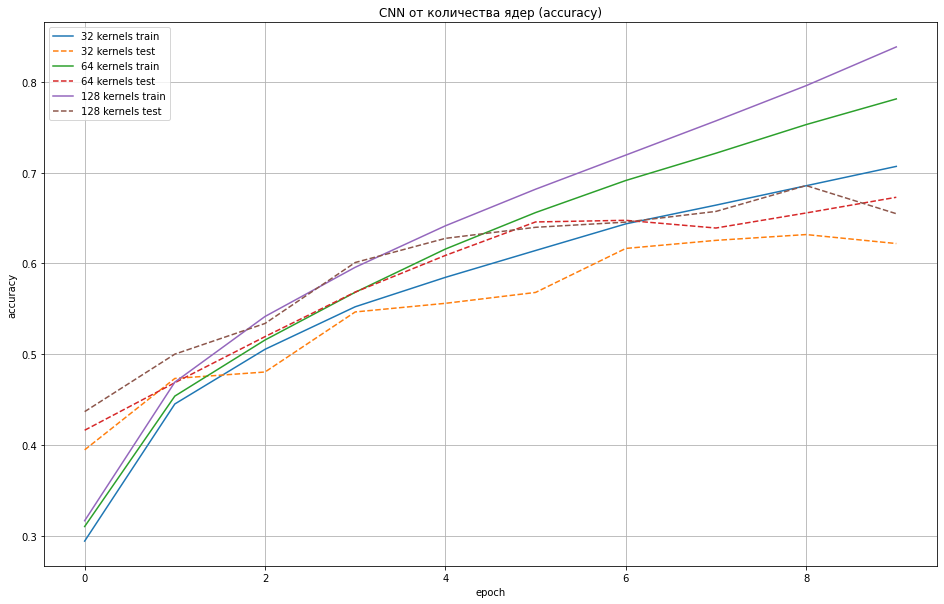

In [12]:
kern_num = [[16, 32],
            [32, 64],
            [64, 128]]
kern = (3, 3)
neur_num = [[128, 10],
            [256, 10],
            [512, 10]]

plt.figure(figsize=(16, 10))

for i in range(len(kern_num)):
    model = Sequential()

    add_conv_pool(model, kern_num[i][0], kern, input_shape=x_train.shape[1:])
    add_conv_pool(model, kern_num[i][1], kern)
    add_dense(model, neur_num[i])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    hist = model.fit(x_train, y_train, batch_size=32, epochs=10, 
                     verbose=0, validation_data=(x_test, y_test))
    
    plt.plot(hist.history['accuracy'], '-', label=f'{kern_num[i][1]} kernels'+' train')
    plt.plot(hist.history['val_accuracy'], '--', label=f'{kern_num[i][1]} kernels'+' test')
plt.legend()
plt.grid('On')

plt.title('CNN от количества ядер (accuracy)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

В целом с лучшей примерно одинаковой точностью обучились модели с 64 и 128 ядрами на крайнем сверточном слое.